In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
#import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [18, 8]

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.alr import ALR_WRP

from teslakit.custom_dateutils import xds_reindex_daily as xr_daily
from teslakit.custom_dateutils import xds_common_dates_daily as xcd_daily
from teslakit.custom_dateutils import xds2datetime as x2d


In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('TESTNEW')


In [3]:
# --------------------------------------
# load data and set parameters

xds_MJO_fit = db.Load_MJO_hist()       # historical MJO
xds_KMA_fit = db.Load_ESTELA_KMA()     # ESTELA + TCs Predictor
xds_PCs = db.Load_SST_PCA()            # SST PCs (annual)

xds_MJO_sim = db.Load_MJO_sim()        # MJO simulation (daily)
xds_PCs_sim = db.Load_SST_PCs_sim_d()  # SST PCs simulation (daily)

# ALR fit parameters
alr_num_clusters = 42
alr_markov_order = 1
alr_seasonality = [2, 4]

# ALR simulation
n_sim = 1


In [4]:
# --------------------------------------
# Data used to FIT ALR model and preprocess: 

# KMA: bmus (daily)
print(xds_KMA_fit)
print()

# MJO: rmm1, rmm2 (daily)
print(xds_MJO_fit)
print()

# SST: PCs (annual)
sst_PCs = xds_PCs.PCs.values[:]
xds_PCs_fit = xr.Dataset(
    {
        'PC1': (('time',), sst_PCs[:,0]),
        'PC2': (('time',), sst_PCs[:,1]),
        'PC3': (('time',), sst_PCs[:,2]),
    },
    coords = {'time': xds_PCs.time.values[:]}
)

# reindex annual data to daily data
xds_PCs_fit = xr_daily(xds_PCs_fit)
print(xds_PCs_fit)


<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 11668, n_features: 432)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 ...
    cenEOFs             (n_clusters, n_features) float64 ...
    centroids           (n_clusters, n_features) float64 ...
    group_size          (n_clusters) int64 ...
    sorted_order        (n_clusters) int64 ...
    sorted_bmus         (n_components) int64 ...
    sorted_cenEOFs      (n_clusters, n_features) float64 ...
    sorted_centroids    (n_clusters, n_features) float64 ...
    time                (n_components) datetime64[ns] ...
    sorted_bmus_storms  (n_components) int64 ...
Attributes:
    method:   regression guided
    alpha:    0.36

<xarray.Dataset>
Dimensions:  (time: 14343)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-04-08
Data variables:
    phase    (time) int64 ...
    rmm1     (time) float64 ...
    r

In [5]:
# --------------------------------------
# Data used to SIMULATE ALR model and preprocess

# MJO: rmm1, rmm2 (daily data)
print(xds_MJO_sim)
print()

# SST: PCs (daily data)
print(xds_PCs_sim)


<xarray.Dataset>
Dimensions:  (time: 365243)
Coordinates:
  * time     (time) object 2020-01-01 00:00:00 ... 3020-01-01 00:00:00
Data variables:
    mjo      (time) float32 ...
    phase    (time) float32 ...
    rmm1     (time) float32 ...
    rmm2     (time) float32 ...

<xarray.Dataset>
Dimensions:  (time: 365243)
Coordinates:
  * time     (time) object 2020-06-01 00:00:00 ... 3020-06-01 00:00:00
Data variables:
    PC1      (time) float32 ...
    PC2      (time) float32 ...
    PC3      (time) float32 ...


In [6]:
# --------------------------------------
# Mount covariates matrix

# available data:
# model fit: xds_KMA_fit, xds_MJO_fit, xds_PCs_fit
# model sim: xds_MJO_sim, xds_PCs_sim

# bmus fit
xds_BMUS_fit = xr.Dataset(
    {
        'bmus':(('time',), xds_KMA_fit['bmus'].values[:]),
    },
    coords = {'time': xds_KMA_fit.time.values[:]}
)

# covariates_fit
d_covars_fit = xcd_daily([xds_MJO_fit, xds_PCs_fit, xds_BMUS_fit])

# KMA dates
xds_BMUS_fit = xds_BMUS_fit.sel(time=slice(d_covars_fit[0],d_covars_fit[-1]))

# PCs covars 
cov_PCs = xds_PCs_fit.sel(time=slice(d_covars_fit[0],d_covars_fit[-1]))
cov_1 = cov_PCs.PC1.values.reshape(-1,1)
cov_2 = cov_PCs.PC2.values.reshape(-1,1)
cov_3 = cov_PCs.PC3.values.reshape(-1,1)

# MJO covars
cov_MJO = xds_MJO_fit.sel(time=slice(d_covars_fit[0],d_covars_fit[-1]))
cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

# join covars 
cov_T = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))

# normalize
cov_norm_fit = (cov_T - cov_T.mean(axis=0)) / cov_T.std(axis=0)
xds_cov_fit = xr.Dataset(
    {
        'cov_norm': (('time','n_covariates'), cov_norm_fit),
        'cov_names': (('n_covariates',), ['PC1','PC2','PC3','MJO1','MJO2']),
    },
    coords = {
        'time': d_covars_fit,
    }
)
print(xds_cov_fit)
print()


# covariates: SIMULATION
d_covars_sim = xcd_daily([xds_MJO_sim, xds_PCs_sim])

# PCs covar 
cov_PCs = xds_PCs_sim.sel(time=slice(d_covars_sim[0],d_covars_sim[-1]))
cov_1 = cov_PCs.PC1.values.reshape(-1,1)
cov_2 = cov_PCs.PC2.values.reshape(-1,1)
cov_3 = cov_PCs.PC3.values.reshape(-1,1)

# MJO covars
cov_MJO = xds_MJO_sim.sel(time=slice(d_covars_sim[0],d_covars_sim[-1]))
cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

# join covars (do not normalize simulation covariates)
cov_T_sim = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))
xds_cov_sim = xr.Dataset(
    {
        'cov_values': (('time','n_covariates'), cov_T_sim),
    },
    coords = {
        'time': d_covars_sim,
    }
)
print(xds_cov_sim)


<xarray.Dataset>
Dimensions:    (n_covariates: 5, time: 11668)
Coordinates:
  * time       (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2011-01-22
Dimensions without coordinates: n_covariates
Data variables:
    cov_norm   (time, n_covariates) float64 -0.1621 0.9171 ... -1.384 2.114
    cov_names  (n_covariates) <U4 'PC1' 'PC2' 'PC3' 'MJO1' 'MJO2'

<xarray.Dataset>
Dimensions:     (n_covariates: 5, time: 365091)
Coordinates:
  * time        (time) object 2020-06-01 2020-06-02 ... 3019-12-31 3020-01-01
Dimensions without coordinates: n_covariates
Data variables:
    cov_values  (time, n_covariates) float32 -13.466496 -6.5152946 ... 1.10329


In [7]:
# --------------------------------------
# Autoregressive Logistic Regression

# available data:
# model fit: xds_KMA_fit, xds_cov_sim, num_clusters
# model sim: xds_cov_sim, sim_num, sim_years


# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : False,
    'seasonality': (True, alr_seasonality),
    'covariates': (True, xds_cov_fit),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.ESTELA.alrw)
ALRW.SetFitData(alr_num_clusters, xds_KMA_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)
    

ALR bmus (fit) saved at /Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/TESTNEW/ESTELA/alr_w/xds_input.nc

Fitting autoregressive logistic model ...
Optimization done in 46.77 seconds

ALR model saved at /Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/TESTNEW/ESTELA/alr_w/model.sav


In [8]:
# Plot model p-values and params
#ALRW.Report_Fit()


In [9]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# launch simulation
dates_sim = d_covars_sim  # simulation dates

xds_alr = ALRW.Simulate(n_sim, dates_sim, xds_cov_sim, progress_bar=True)

# Store Daily Weather Types
xds_DWT_sim = xds_alr.evbmus_sims.to_dataset()
print(xds_DWT_sim)

db.Save_ESTELA_DWT_sim(xds_DWT_sim)


ALR model fit   : 1979-02-12T00:00:00.000000000 --- 2011-01-22T00:00:00.000000000
ALR model sim   : 2020-06-01 00:00:00 --- 3020-01-01 00:00:00

Launching simulations...

Sim. Num. 001 |██████████████████████████████████████████████████| 100.0% Complete
<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 365091)
Coordinates:
  * time         (time) datetime64[ns] 2020-06-01 ... 1850-11-22T00:50:52.580896768
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float64 5.0 6.0 7.0 36.0 ... 2.0 24.0 20.0 7.0


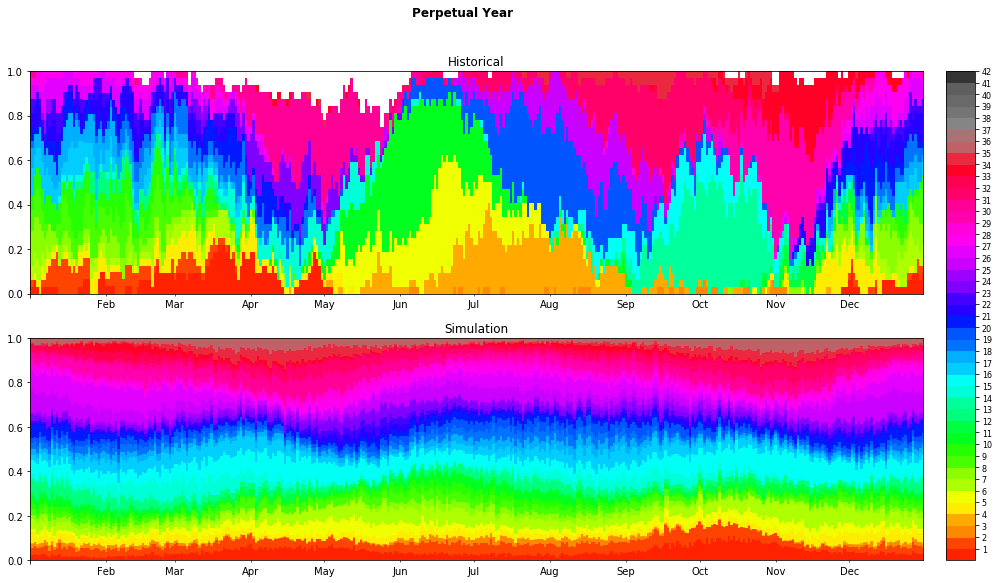

In [10]:
# show sim report
ALRW.Report_Sim()
